## Imports

In [32]:
!hostnamectl

 Static hostname: DGX
       Icon name: computer-server
         Chassis: server 🖳
      Machine ID: dedf5691225742ff95b33f842b0781cc
         Boot ID: cb04df0ff1774eeda112c63867eeefdd
Operating System: ]8;;https://www.ubuntu.com/Ubuntu 24.04.2 LTS]8;;              
          Kernel: Linux 6.8.0-53-generic
    Architecture: x86-64
 Hardware Vendor: NVIDIA
  Hardware Model: DGXA100 920-23687-2530-002
Firmware Version: 1.29
   Firmware Date: Tue 2024-08-06
    Firmware Age: 7month


In [ ]:
%pip install -r requirements.txt

import sys
import os
sys.path.append('../src')
from data_preprocessing import data_preprocessing_tumor
from model import BrainCNN, EarlyStopping
from collections import defaultdict



import torch
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix




In [34]:
train_loader, test_loader = data_preprocessing_tumor()
print("data was successfully loaded")

data was successfully loaded


In [35]:
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")


Train dataset size: 5712
Test dataset size: 1311


In [ ]:

def count_images_per_class(loader):
    class_counts = defaultdict(int)

    for _, labels in loader:
        for label in labels:
            class_counts[label.item()] += 1 

    return class_counts

train_class_counts = count_images_per_class(train_loader)
test_class_counts = count_images_per_class(test_loader)

print("Train loader class counts:")
for class_label, count in train_class_counts.items():
    print(f"Class {class_label}: {count} images")

print("\nTest loader class counts:")
for class_label, count in test_class_counts.items():
    print(f"Class {class_label}: {count} images")


Train loader class counts:
Class 2: 1595 images
Class 3: 1457 images
Class 0: 1321 images
Class 1: 1339 images

Test loader class counts:
Class 0: 300 images
Class 1: 306 images
Class 2: 405 images
Class 3: 300 images


In [37]:
# Hyperparameters

num_epochs=50
patience=10
learning_rate=0.001
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = BrainCNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-3)
early_stopping = EarlyStopping(patience=patience, delta=0.0005)

# Metrics for runtime calculations

train_loss_metr = []
val_loss_metr = []

train_acc_metr = []
val_acc_metr = []

# Model training

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
        _, predicted = torch.max(output, 1)         # Caluclating metrics for test set
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()
        
        
        
    train_loss /= len(train_loader.dataset)
    train_acc = correct_train / total_train
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_targets = []
    val_preds = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            
            _, predicted = torch.max(output, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()
            
            val_targets.extend(target.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())
    
    val_loss /= len(test_loader.dataset)
    val_acc = correct_val / total_val
    
    train_loss_metr.append(train_loss)
    val_loss_metr.append(val_loss)
    train_acc_metr.append(train_acc)
    val_acc_metr.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break 



torch.save(model.state_dict(), "./braincnn_prototype.weights")

Epoch 1: Train Loss: 0.5462, Val Loss: 0.5733
Epoch 2: Train Loss: 0.2847, Val Loss: 0.3455
Epoch 3: Train Loss: 0.1784, Val Loss: 0.2046
Epoch 4: Train Loss: 0.0965, Val Loss: 0.4274
Epoch 5: Train Loss: 0.0754, Val Loss: 0.1584
Epoch 6: Train Loss: 0.0602, Val Loss: 0.2601
Epoch 7: Train Loss: 0.0268, Val Loss: 0.1449
Epoch 8: Train Loss: 0.0270, Val Loss: 0.1621
Epoch 9: Train Loss: 0.0110, Val Loss: 0.0633
Epoch 10: Train Loss: 0.0040, Val Loss: 0.0885
Epoch 11: Train Loss: 0.0013, Val Loss: 0.0573
Epoch 12: Train Loss: 0.0007, Val Loss: 0.0626
Epoch 13: Train Loss: 0.0004, Val Loss: 0.0618
Epoch 14: Train Loss: 0.0005, Val Loss: 0.0647
Epoch 15: Train Loss: 0.0003, Val Loss: 0.0581
Epoch 16: Train Loss: 0.0002, Val Loss: 0.0590
Epoch 17: Train Loss: 0.0002, Val Loss: 0.0586
Epoch 18: Train Loss: 0.0002, Val Loss: 0.0596
Epoch 19: Train Loss: 0.0002, Val Loss: 0.0592
Epoch 20: Train Loss: 0.0002, Val Loss: 0.0622
Epoch 21: Train Loss: 0.0002, Val Loss: 0.0599
Early stopping


In [41]:
early_stopping.load_best_model(model)

# Final evaluation on the test set
model.eval()
correct = 0
total = 0
test_targets = []
test_preds = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        test_targets.extend(target.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())

test_accuracy =  correct / total

precision = precision_score(test_targets, test_preds, average='weighted')
recall = recall_score(test_targets, test_preds, average='weighted')
f1 = f1_score(test_targets, test_preds, average='weighted')

# Print the results
print('Metrics of the model on the test images:')
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

with open("training_metrics.pkl", "wb") as f:
    pickle.dump({
        "train_loss": train_loss_metr,
        "val_loss": val_loss_metr,
        "train_acc": train_acc_metr,
        "val_acc": val_acc_metr,
        "accuracy": test_accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }, f)

torch.save(model.state_dict(), "./braincnn_prototype.weights")

Metrics of the model on the test images:
Accuracy: 0.9847
Precision: 0.9849
Recall: 0.9847
F1 Score: 0.9847


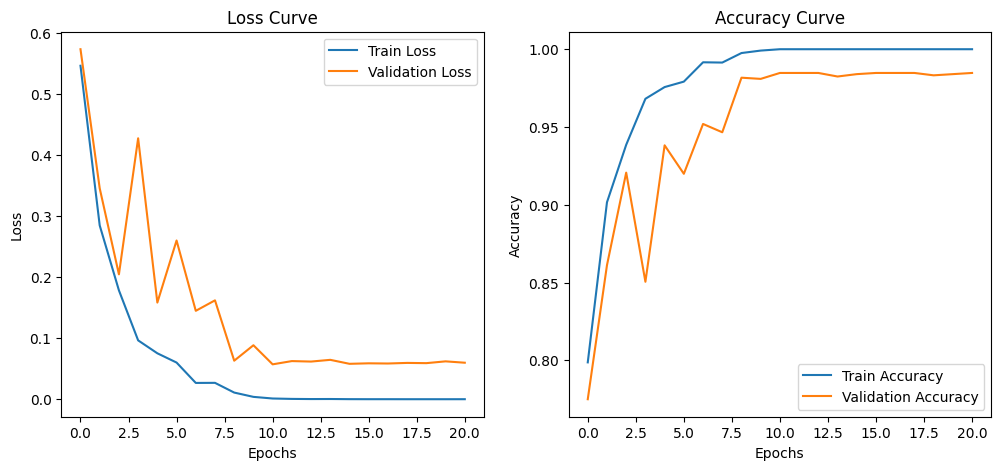

In [42]:
# Load metrics
with open("training_metrics.pkl", "rb") as f:
    metrics = pickle.load(f)

train_loss_metr = metrics["train_loss"]
val_loss_metr = metrics["val_loss"]
train_acc_metr = metrics["train_acc"]
val_acc_metr = metrics["val_acc"]

plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_loss_metr, label='Train Loss')
plt.plot(val_loss_metr, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_acc_metr, label='Train Accuracy')
plt.plot(val_acc_metr, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.savefig("training_plots.png", dpi=300, bbox_inches="tight")
plt.show()


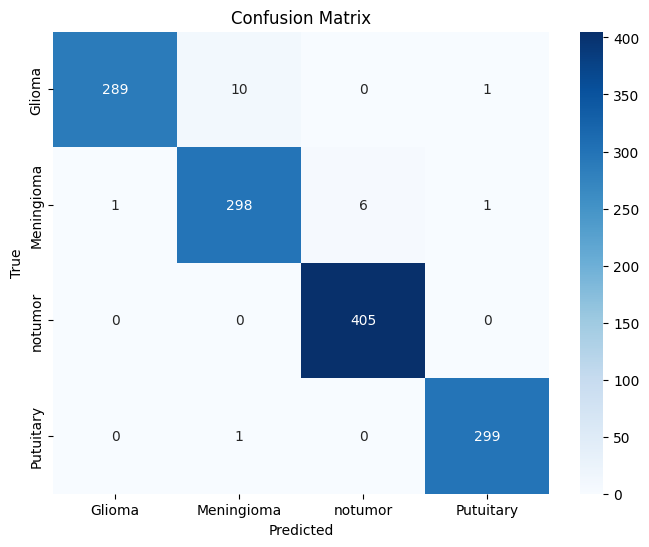

In [43]:
cm = confusion_matrix(test_targets, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Glioma', 'Meningioma', 'notumor', 'Putuitary'], 
            yticklabels=['Glioma', 'Meningioma', 'notumor', 'Putuitary'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()
